# Basic Usage of System 3.0 API

This notebook provides basic examples of how to use System 3.0's APIs. For the full API documentation please refer to [here](http://system-3.0-openapi-documentation.s3-website-us-east-1.amazonaws.com/#/).

<a target="_blank" href="https://colab.research.google.com/github/SystemInternal/SystemCookbook/blob/master/system_api/system_api_basics.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Start by installing System API's Python SDK and other required libraries.

In [ ]:
!pip install --upgrade pip
!pip install soh-service-client==1.48.0 --extra-index-url https://pypi.fury.io/systeminc/
!apt install libgraphviz-dev
!pip install matplotlib networkx pygraphviz

### 0. import libraries and define a few helper functions

In [ ]:
!pip list

In [ ]:
import soh_service_client
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt

In [13]:
def pprint_finding(f):
    print(f"{f.variable_1_name} - ({f.statistic_type}: {f.statistic_value}) -> {f.variable_2_name}")

def pprint_topic(t):
    print(f"{t.name} ({t.topic_id})")

def draw_star(nodes, links):
    node_name_lookup = {node.topic_id: node.name for node in nodes}
    source_nodes = [node_name_lookup.get(link.source, link.source) for link in links]
    target_nodes = [node_name_lookup.get(link.target, link.target) for link in links]
    edges = [(source_nodes[i], target_nodes[i]) for i in range(len(source_nodes))]
    nodes = source_nodes + target_nodes
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node)
    for edge in edges:
        G.add_edge(edge[0], edge[1])

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=20, node_color="skyblue", font_size=8, font_weight="bold", font_color="black", edge_color="gray", width=1, alpha=0.5)
    plt.show()

def draw_dag(paths):
    links = paths.links
    node_name_lookup = {node.topic_id: node.name for node in paths.nodes}
    source_nodes = [node_name_lookup.get(link.source, link.source) for link in links]
    target_nodes = [node_name_lookup.get(link.target, link.target) for link in links]
    edges = [(source_nodes[i], target_nodes[i]) for i in range(len(source_nodes))]
    edge_value_raw = [link.median_effect_size for link in links]
    edge_value = [round(value, 2) if value is not None else "" for value in edge_value_raw]
    nodes = source_nodes + target_nodes
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node)
    for edge in edges:
        G.add_edge(edge[0], edge[1], weight=edge_value[edges.index(edge)])

    pos = nx.nx_agraph.graphviz_layout(G, prog="dot", args='-Grankdir=LR')
    nx.draw(G, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_weight="bold", font_color="black", edge_color="gray", width=2, alpha=0.5)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()


### 1. Create a SOH Service Client and initialize various endpoints

In [33]:
API_KEY = "i3JIEwgf9D3hmar0ZYAKW1bxaOX2hxfz1On4ROCD"
system_client = soh_service_client.ApiClient(header_name="x-api-key", header_value=API_KEY)

topic_api = soh_service_client.api.topics_api.TopicsApi(system_client)
findings_api = soh_service_client.api.findings_api.FindingsApi(system_client)
StatRelationshipsApi = soh_service_client.api.StatisticalRelationshipsApi(system_client)
MechRelationshipsApi = soh_service_client.api.MechanisticRelationshipsApi(system_client)

### 2. Search for a topic
Let's start by searching for a topic on System. The API returns all semantically relevant nodes of the graph alonside their metadata.

In [34]:
topic_of_interest = "malaria"
fetched_topics = topic_api.fetch_topics_topics_get(query=topic_of_interest)
topics_json = [json.loads(topic.json()) for topic in fetched_topics]
df = pd.DataFrame(topics_json)
df

,name,topic_id,umls_cuis,umls_children,wikidata_id,roles,category,mechanistic_category,relationship_types
0,malaria,7xpZryeSKE,[C0024530],[],Q12156,"[Determinant, Outcome, Agent]",Biomedical - Diseases & disorders,diseases & disorders,"[statistical, mechanistic]"
1,malaria prevalence,wYL8n9x4mu,[],[],Q113361605,"[Determinant, Outcome]",Biomedical - Diseases & disorders,None,[statistical]
2,malaria vaccine,vtzCBL9BRr,[C0206255],[],Q6741353,[Intervention],Preventative,None,[statistical]
3,avian malaria,ug1mEfyCUG,[C0024533],[],Q2663527,"[Determinant, Outcome]",Biomedical - Diseases & disorders,None,[statistical]
4,cerebral malaria,gjXBGUnKoK,[C0024534],[],Q2822915,"[Determinant, Outcome, Agent]",Biomedical - Diseases & disorders,diseases & disorders,"[statistical, mechanistic]"
5,Plasmodium falciparum malaria,n8o7PdNYDI,[C0024535],[],Q18554672,"[Determinant, Outcome, Agent]",Biomedical - Diseases & disorders,diseases & disorders,"[statistical, mechanistic]"
6,plasmodium vivax malaria,gdUTojmkBD,[C0024537],[],Q18554412,"[Determinant, Outcome]",Biomedical - Diseases & disorders,None,"[statistical, mechanistic]"
7,plasmodium malariae,GuVqtviR9c,[C0032153],[],Q133969,"[Determinant, Outcome]",Biomedical - Diseases & disorders,None,[statistical]


### 3. Fetch all extracted findings from a paper
System continuously extracts statistical and mechanistic relationships from the literature. You can see all extracted findings for a given paper using its DOI:

In [35]:
res = findings_api.fetch_findings_findings_log_get("10.1016/j.trstmh.2008.11.016")
res.study.title
for f in res.findings:
    pprint_finding(f)

household wealth - (odds_ratio: 0.79) -> malaria prevalence
living at higher altitude - (odds_ratio: 0.95) -> malaria prevalence
number of long-lasting insecticidal nets (LLINs) per household - (odds_ratio: 0.6) -> malaria prevalence
peak monthly rainfall in the year before the survey - (odds_ratio: 1.1) -> malaria prevalence


### 4. Fetch the entire subgraph.
You can fetch the entire system around a node of interest with the following code:

The topic of interest is malaria with topic_id 7xpZryeSKE.
There are 75 nodes and 98 links in the graph.


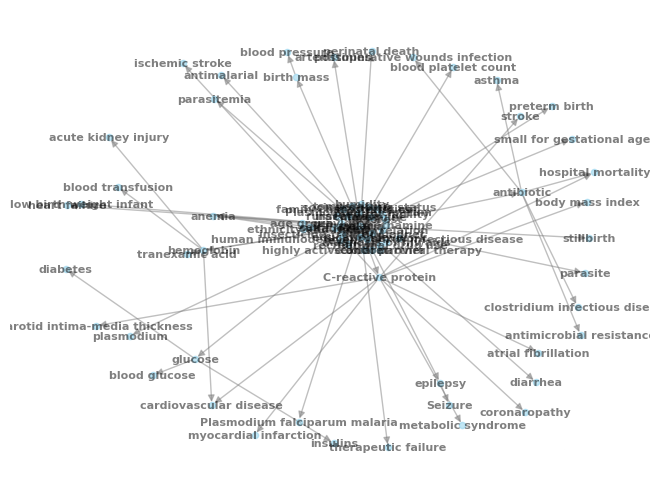

In [36]:
topic_id = topic_api.fetch_topics_topics_get(topic_of_interest)[0].topic_id
print(f"The topic of interest is {topic_of_interest} with topic_id {topic_id}.")
gp=soh_service_client.models.GraphPayload()
res = StatRelationshipsApi.fetch_full_graph_stat_relationships_topic_id_graph_post(topic_id, gp)
print(f"There are {len(res.nodes)} nodes and {len(res.links)} links in the graph.")
draw_star(res.nodes, res.links)

Let's bucket and count different nodes of the above graph:

In [37]:
for role in soh_service_client.models.Role:
    node_type = [node for node in res.nodes if role in node.roles]
    print(f"Number of {role.value}s: {len(node_type)}")

Number of Determinants: 59
Number of Interventions: 15
Number of Outcomes: 56
Number of Agents: 34


### 5. Find mediators between two topics

Let's find all the potential mediators between "temperature" and "malaria"

malaria (7xpZryeSKE)
temperature (4FaXcuNJRt)


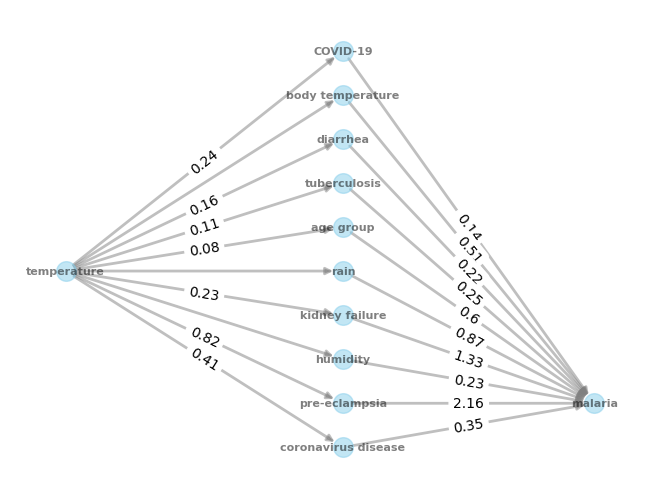

In [38]:
second_topic = "temperature"
node_1 = topic_api.fetch_topics_topics_get(topic_of_interest)[0]
node_2 = topic_api.fetch_topics_topics_get(second_topic)[0]
pprint_topic(node_1)
pprint_topic(node_2)
pathsPayload = soh_service_client.models.PathsPayload(n_hop=2)
paths = StatRelationshipsApi.fetch_stat_mediators_stat_relationships_topic_id_paths_mediators_post(
    topic_id=node_2.topic_id,
    target_topic_id=node_1.topic_id,
    paths_payload=pathsPayload
    )
draw_dag(paths)

### 6. Traversing the graph
Starting from a node, you can traverse the graph 1 or 2 hops in upstream or downstream directions.

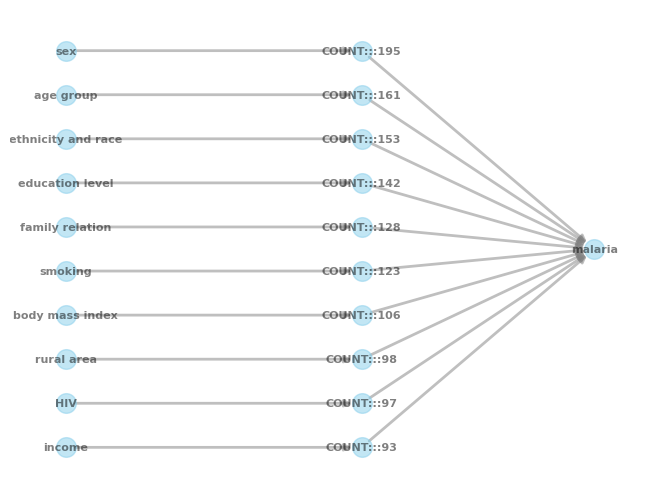

In [39]:
topic_id = topic_api.fetch_topics_topics_get(topic_of_interest)[0].topic_id
pathsPayload = soh_service_client.models.PathsPayload(n_hop=2)
paths = StatRelationshipsApi.fetch_stat_paths_stat_relationships_topic_id_paths_traversal_direction_post(
    topic_id=topic_id,
    traversal_direction="upstream",
    paths_payload=pathsPayload)
draw_dag(paths)

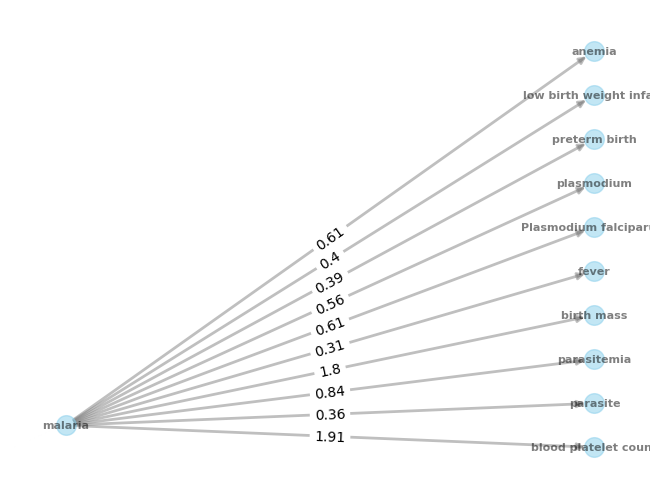

In [40]:
pathsPayload = soh_service_client.models.PathsPayload(n_hop=1)
paths = StatRelationshipsApi.fetch_stat_paths_stat_relationships_topic_id_paths_traversal_direction_post(
    topic_id=topic_id,
    traversal_direction="downstream",
    paths_payload=pathsPayload)
draw_dag(paths)